## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
print(f"GPUs: {len(tf.config.list_physical_devices('GPU'))}")
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

from DataGen import VQASequence
from json_to_df import gen_df

GPUs: 1


## Hyperparameters

In [2]:
img_size = 224
img_input_shape = (img_size, img_size, 3)
qstn_input_shape = (None, 300)
n_most_freq = 200
seed = 14
test_size = 0.2
learning_rate = 1e-3
batch_size = 256
epochs=100

## Data

In [3]:
train_df = gen_df('train')
val_df = gen_df('val')

df = pd.concat([train_df, val_df])

most_freq = df.Question.value_counts().head(n_most_freq).index
df = df[df.Question.isin(most_freq)]

train_df, temp_df = train_test_split(df, test_size=test_size, stratify=df.Question, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df.Question, random_state=seed)

<AxesSubplot:>

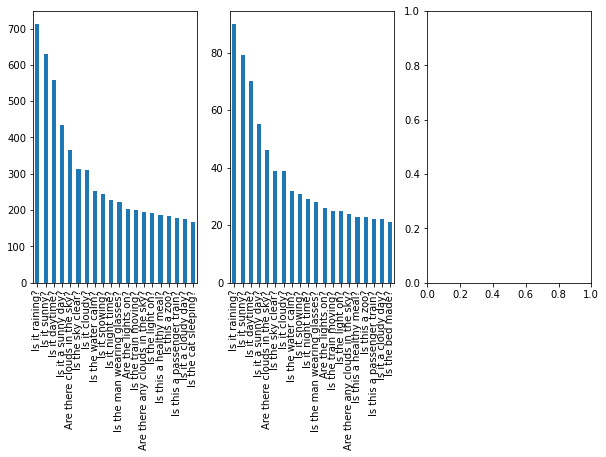

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

train_df.Question.value_counts()[:20].plot.bar(ax=axes[0])
val_df.Question.value_counts()[:20].plot.bar(ax=axes[1])
test_df.Question.value_counts()[:20].plot.bar(ax=axes[2])

In [5]:
train_gen = VQASequence(batch_size, train_df, img_size)
val_gen = VQASequence(batch_size, val_df, img_size)
test_gen = VQASequence(batch_size, test_df, img_size)

## Model

In [6]:
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=img_input_shape,
    pooling='max'
)
for layer in vgg.layers: layer.trainable = False
    
img_x = vgg.output
img_x = Flatten()(img_x)
img_x = Dense(1024, activation='relu')(img_x)
img_x = BatchNormalization()(img_x)
img_output = Dense(1024, activation='relu')(img_x)

# Question
qstn_input = Input(shape=qstn_input_shape, dtype="float32")
qstn_x = LSTM(2048, activation='tanh')(qstn_input)
qstn_x = BatchNormalization()(qstn_x)
qstn_x = Dense(1024, activation='relu')(qstn_x)
qstn_x = BatchNormalization()(qstn_x)
qstn_output = Dense(1024, activation='relu')(qstn_x)

concat = Concatenate(axis=1)([img_output, qstn_output])
x = Dense(1024, activation='relu')(concat)
x = Dropout(0.15)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.15)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.15)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(
    inputs=[vgg.input, qstn_input], 
    outputs=output, 
    name='BiModal_VQA'
)


In [7]:
metrics = ['accuracy', 'AUC', 'Precision', 'Recall']

model.compile(
    optimizer=Adam(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=metrics
)

rp = ReduceLROnPlateau(patience=5)
es = EarlyStopping(patience=15)

callbacks= [rp, es]

## Train

In [ ]:
%%time

hist = model.fit(
    x=train_gen,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_gen,
    callbacks=callbacks
)


Epoch 1/100
74/74 [==============================] - 189s 2s/step - loss: 0.9591 - accuracy: 0.5263 - auc: 0.5259 - precision: 0.5569 - recall: 0.5745 - val_loss: 0.7383 - val_accuracy: 0.5443 - val_auc: 0.5230 - val_precision: 0.5594 - val_recall: 0.7516
Epoch 2/100
74/74 [==============================] - 102s 1s/step - loss: 0.7109 - accuracy: 0.5714 - auc: 0.5973 - precision: 0.5913 - recall: 0.6436 - val_loss: 0.6995 - val_accuracy: 0.5473 - val_auc: 0.5512 - val_precision: 0.5474 - val_recall: 0.9525
Epoch 3/100
74/74 [==============================] - 102s 1s/step - loss: 0.6759 - accuracy: 0.5989 - auc: 0.6356 - precision: 0.6117 - recall: 0.6916 - val_loss: 0.6896 - val_accuracy: 0.5676 - val_auc: 0.5817 - val_precision: 0.5802 - val_recall: 0.7321
Epoch 4/100
74/74 [==============================] - 102s 1s/step - loss: 0.6373 - accuracy: 0.6400 - auc: 0.6915 - precision: 0.6580 - recall: 0.6970 - val_loss: 0.6732 - val_accuracy: 0.5743 - val_auc: 0.6031 - val_precision: 0.57

## Plot

In [ ]:
pickle.dump(hist.history, open(f'./{model.name}.pickle', 'wb'))

def plot(history, metrics):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss', color='red')
    plt.legend()
    plt.figsave(f'./plots/{model.name}_loss.png')
    plt.show()
    
    for metric in metrics:
        metric = metric.lower()
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}', color='red')
        plt.legend()
        plt.figsave(f'./plots/{model.name}_{metric}.png')
        plt.show()
    
plot(model.history, metrics)

## Evalaution

In [ ]:
evaluate = model.evaluate(x=test_gen, batch_size=batch_size, verbose=0)

results_dict = {
    'Name' : model.name,
    'Loss' : [evaluate[0]],
    'Accuracy' : [evaluate[1]],
    'AUC' : [evaluate[2]],
    'Precision' : [evaluate[3]],
    'Recall' : [evaluate[4]]
}

test_results = pd.DataFrame(data=results_dict)
test_results.head(1)
test_resuls.to_csv(f'./results/{model.name}_results.png')